# Crash study on I-95 till September 2022

### <span style='color:blue'> Crash index define </span> :  Crash rate per month, which is count of <span style='color:blue'>  total crashes </span>  divided by the span of <span style='color:blue'> total months </span> 

# Outline
### [Study location and timeframe define](#Define-qry)
### [Crash number Comparison before and after](#Rte-plot-by-milemarker-compare-before-and-after-2022)
### [Crash number on focusing segment](#Compare-Before-and-After-for-heavy-segment-area)
### [Crash type and Severity Comparison on focusing segment](#Comparison-on-severity-and-collision-types-before-and-after)
### [Heat Map Comparison](#Comparison-of-Heatmap-between-crash-and-non-crash-condition)


In [42]:
import pandas as pd
import numpy as np
from termcolor import colored
import plotly.express as px
import plotly.graph_objects as go
import nbformat
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Define qry

In [43]:
# Query to filter rows where route name is either "R-VA   IS00095SB" or "R-VA   IS00095NB"
RTE_qry = '(RTE_NM == "R-VA   IS00095SB" or RTE_NM == "R-VA   IS00095NB")'

# Query to filter rows where milepost is between 75 and 78 inclusive
area_qry = 'RNS_MP >= 75 and RNS_MP <= 78'

# Query to filter rows where crash year is before 2020
before_qry = 'CRASH_YEAR < 2020'

# Query to filter rows where crash year is 2021 or later
after_qry = 'CRASH_YEAR >= 2021'


## Update to pull volume and speed info

In [44]:
df = pd.read_csv('Crash_Data.csv')

C:\windows\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning:

Columns (47,49,51,53) have mixed types.Specify dtype option on import or set low_memory=False.



In [45]:
df_map  = pd.read_csv('Crash_Data (1).csv')

In [46]:
# Convert CRASH_DT to datetime format once and reuse
crash_datetime = pd.to_datetime(df_map['CRASH_DT'])

# Create new columns based on CRASH_DT
df_map['Date'] = pd.to_numeric(crash_datetime.dt.strftime('%Y%m%d'))
df_map['YrMon'] = crash_datetime.dt.strftime('%Y-%m')
df_map['Mon'] = crash_datetime.dt.month  # Already numeric, no need to format and then convert
df_map['wkdays'] = crash_datetime.dt.dayofweek

# Create the 'Hr' column based on CRASH_MILITARY_TM
df_map['Hr'] = (df_map['CRASH_MILITARY_TM'] // 100).astype(int)  # Using floor division


In [47]:
decimals = 0    
df_map['mile_marker'] = df_map['RNS_MP'].apply(lambda x: round(x, decimals))

## Rte plot by milemarker compare before and after 2022

In [48]:
# Filter based on RTE_qry and directly modify for plotting
df_rte = df_map.query(RTE_qry)
Year_range = len(df_rte['YrMon'].unique())

# Create the CR_index column
df_rte['CR_index'] = 1 / Year_range

# Plotting
fig = px.histogram(df_rte,
                   x="mile_marker",
                   y="CR_index",
                   nbins=200,
                   title="data till 09/2022",
                   histfunc='sum')
fig.update_layout(bargap=0.1)
fig.show()

# Calculate and print the average crash rate
average_CR_rte = df_rte.groupby('mile_marker')['CR_index'].sum().mean()
print(f"Average crash rate per mile per month: {colored(round(average_CR_rte, 2), 'blue')}")


C:\Users\enhua.liu\AppData\Local\Temp/ipykernel_25240/809169910.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Average crash rate per mile per month: 2.48


In [49]:
def prepare_data(df, query_str):
    df_filtered = df.query(query_str).copy()
    year_range = len(df_filtered['YrMon'].unique())
    df_filtered['CR_index'] = 1 / year_range
    return df_filtered

df_rte_b4 = prepare_data(df_rte, before_qry)
df_rte_af = prepare_data(df_rte, after_qry)

fig = go.Figure()

# Create histograms
hist_params = {
    'histfunc': 'sum',
    'xbins': {'size': 1}
}

fig.add_trace(go.Histogram(name='after', x=df_rte_af['mile_marker'], y=df_rte_af['CR_index'], marker_color='#d62728', opacity=0.85, **hist_params))
fig.add_trace(go.Histogram(name='before', x=df_rte_b4['mile_marker'], y=df_rte_b4['CR_index'], marker_color='#1f77b4', opacity=0.5, **hist_params))

# Update layout
fig.update_layout(title={'text': "Comparison Before and After"}, barmode='overlay')

# Calculate and print the average crash rate
average_CR_rte = df_rte.groupby('mile_marker')['CR_index'].sum().mean()
print(f"Average crash rate per mile per month: {colored(round(average_CR_rte, 2), 'blue')}")
print(f"Before: {before_qry}")
print(f"After: {after_qry}")

fig.show()


Average crash rate per mile per month: 2.48
Before: CRASH_YEAR < 2020
After: CRASH_YEAR >= 2021


### [Back to Top](#Outline)

# Focus on the heavy segment area

In [50]:
# Filter data and create a new DataFrame
df_area = df_map.query(f"{RTE_qry} and {area_qry}")

# Extract the Direction information from RTE_NM and create a new column
df_area['Direction'] = df_area['RTE_NM'].str[-2:-1]


C:\Users\enhua.liu\AppData\Local\Temp/ipykernel_25240/1569700624.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Compare Before and After for heavy segment area

In [51]:
# Group and aggregate data for 'before' and 'after' periods
df_index_dist_b4 = df_rte_b4.query(area_qry).groupby('mile_marker')['CR_index'].sum()
df_index_dist_af = df_rte_af.query(area_qry).groupby('mile_marker')['CR_index'].sum()

# Print summary information
print(colored("Area focusing", 'blue'), '\n\n', area_qry, '\n')
print(f"{before_qry} {after_qry}\n")
print(f"Average crashes per month before: {colored(round(df_index_dist_b4.sum(), 2), 'blue')}\n")
print(f"Average crashes per month after: {colored(round(df_index_dist_af.sum(), 2), 'red')}\n")


Area focusing 

 RNS_MP >= 75 and RNS_MP <= 78 

CRASH_YEAR < 2020 CRASH_YEAR >= 2021

Average crashes per month before: 24.58

Average crashes per month after: 29.1



In [52]:
def prepare_data(df, query_str):
    df_filtered = df.query(query_str).copy()
    year_range = len(df_filtered['YrMon'].unique())
    df_filtered['CR_index'] = 1 / year_range
    return df_filtered

# Prepare data
df_area_b4 = prepare_data(df_area, before_qry)
df_area_af = prepare_data(df_area, after_qry)

# Common histogram parameters
hist_params = {
    'histfunc': 'sum',
    'xbins': {'size': 1}
}

fig = go.Figure()

# Add histograms to figure
fig.add_trace(go.Histogram(name='after', x=df_area_af['Hr'], y=df_area_af['CR_index'], marker_color='#d62728', opacity=0.85, **hist_params))
fig.add_trace(go.Histogram(name='before', x=df_area_b4['Hr'], y=df_area_b4['CR_index'], marker_color='#1f77b4', opacity=0.5, **hist_params))

# Update layout and show figure
fig.update_layout(title={'text': "Average crashes monthly by hour, comparison before and after 2022"}, barmode='overlay')
fig.show()


### [Back to Top](#Outline)

## Comparison on severity and collision types before and after

CRASH_YEAR < 2020 CRASH_YEAR >= 2021 


Crash rates per month comparison by COLLISION_TYPE


COLLISION_TYPE 
 CR_index_before 
 CR_index_after 
 percent_change 
 
 
 
 
 0 
 1. Rear End 
 15.68 
 17.50 
 11.58 
 
 
 1 
 10. Deer 
 0.02 
 0.00 
 -100.00 
 
 
 2 
 12. Ped 
 0.03 
 0.00 
 -100.00 
 
 
 3 
 15. Backed Into 
 0.02 
 0.05 
 200.00 
 
 
 4 
 16. Other 
 0.52 
 0.90 
 74.19 
 
 
 5 
 2. Angle 
 2.02 
 1.85 
 -8.26 
 
 
 6 
 3. Head On 
 0.02 
 0.05 
 200.00 
 
 
 7 
 4. Sideswipe - Same Direction 
 3.57 
 5.15 
 44.39 
 
 
 8 
 5. Sideswipe - Opposite Direction 
 0.02 
 0.05 
 200.00 
 
 
 9 
 6. Fixed Object in Road 
 0.30 
 0.30 
 0.00 
 
 
 10 
 8. Non-Collision 
 0.05 
 0.05 
 0.00 
 
 
 11 
 9. Fixed Object - Off Road 
 2.35 
 3.20 
 36.17


Crash rates per month comparison by CRASH_SEVERITY


CRASH_SEVERITY 
 CR_index_before 
 CR_index_after 
 percent_change 
 
 
 
 
 0 
 A. Severe Injury 
 0.60 
 0.95 
 58.33 
 
 
 1 
 B. Visible Injury 
 4.72 
 6.70 
 42.05 
 
 
 2 
 C. Nonvisible Injury 
 0.72 
 0.65 
 -9.30 
 
 
 3 
 K. Fatal Injury 
 0.03 
 0.05 
 50.00 
 
 
 4 
 PDO. Property Damage Only 
 18.52 
 20.75 
 12.06

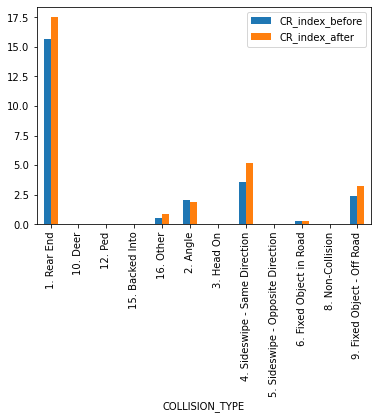

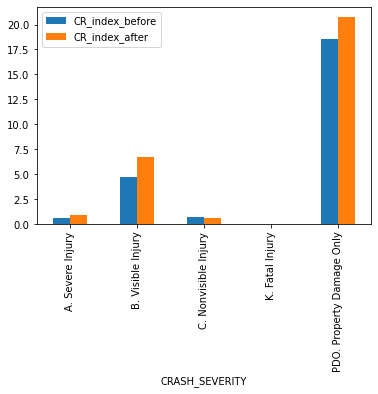

In [53]:
def summarize_and_plot(df_before, df_after, group_col):
    df_before_grouped = df_before.groupby(group_col).agg({'CR_index': 'sum'})
    df_after_grouped = df_after.groupby(group_col).agg({'CR_index': 'sum'})
    
    df_summary = pd.merge(df_before_grouped, df_after_grouped, how='left', on=group_col).reset_index()
    df_summary.columns = [col.replace('_x', '_before').replace('_y', '_after') for col in df_summary.columns]
    df_summary.fillna(0, inplace=True)
    df_summary['percent_change'] = (df_summary['CR_index_after'] - df_summary['CR_index_before']) / df_summary['CR_index_before'] * 100
    
    print(f"\nCrash rates per month comparison by {colored(group_col, 'green')}")
    display_side_by_side(df_summary)
    df_summary.plot(x=group_col, y=["CR_index_before", "CR_index_after"], kind="bar")

# Formatting for float display
pd.options.display.float_format = '{:,.2f}'.format

# Collision Type Summary and Plot
print(colored(before_qry, 'blue'), colored(after_qry, 'red'), "\n")
summarize_and_plot(df_area_b4, df_area_af, 'COLLISION_TYPE')

# Crash Severity Summary and Plot
summarize_and_plot(df_area_b4, df_area_af, 'CRASH_SEVERITY')


### [Back to Top](#Outline)

### Counter speed data

In [54]:
# Read the necessary columns directly
df_conf = pd.read_csv('INRIX_Speed_pull\\INRIX\\conflation_LINKID.csv', usecols=["Milemarker", "Direction", "LINKID"])

# Drop duplicates and reset index in one chain
df_conf_mile = df_conf.drop_duplicates().reset_index(drop=True)

# Read the speed data
df_vol_spd = pd.read_table('INRIX_Speed_pull\\INRIX\\Hourly_volume\\speeddata.csv', sep=',')
# Rename columns
df_vol_spd.columns = ["LINKID", "DateTime", "Dir", "CounterNumber", "Lane", "MPH_0_15", "MPH_15_25", "MPH_25_30", "MPH_30_35", "MPH_35_40", "MPH_40_45", "MPH_45_50", "MPH_50_55", "MPH_55_60", "MPH_60_65", "MPH_65_70", "MPH_70_75", "MPH_75_80", "MPH_80_85", "MPH_85_UP", "TotalVol","VolQual"]

# Convert DateTime to pandas datetime object
df_vol_spd['DateTime'] = pd.to_datetime(df_vol_spd['DateTime'])

# Extract Date, Year, Month, Day, and Hour
df_vol_spd['Date'] = df_vol_spd['DateTime'].dt.strftime('%Y%m%d').astype(int)
df_vol_spd['Year'] = df_vol_spd['DateTime'].dt.year
df_vol_spd['Mon'] = df_vol_spd['DateTime'].dt.month
df_vol_spd['Day'] = df_vol_spd['DateTime'].dt.day
df_vol_spd['Hour'] = df_vol_spd['DateTime'].dt.hour


In [55]:
# Define the midpoints for each speed bin
speed_bin_midpoints = {
    'MPH_0_15': 7.5,
    'MPH_15_25': 20,
    'MPH_25_30': 27.5,
    'MPH_30_35': 32.5,
    'MPH_35_40': 37.5,
    'MPH_40_45': 42.5,
    'MPH_45_50': 47.5,
    'MPH_50_55': 52.5,
    'MPH_55_60': 57.5,
    'MPH_60_65': 62.5,
    'MPH_65_70': 67.5,
    'MPH_70_75': 72.5,
    'MPH_75_80': 77.5,
    'MPH_80_85': 82.5,
    'MPH_85_UP': 82.5
}

# Calculate AvgSpd using dot product
df_vol_spd['AvgSpd'] = df_vol_spd[list(speed_bin_midpoints.keys())].dot(pd.Series(speed_bin_midpoints)) / df_vol_spd['TotalVol']

# Perform the join operation
df_vol_spd_join = pd.merge(df_vol_spd, df_conf_mile, how='left', on='LINKID')


### Crash and no crash vol spd comparison

In [65]:
# Merge df_area and df_vol_spd_join based on common columns. This gives us the crash-related volume and speed data.
# We use a left merge to keep all the rows from df_area and bring in matching rows from df_vol_spd_join.
df_cr_volspd = pd.merge(df_area, df_vol_spd_join, how='left', left_on=['Direction', 'mile_marker', 'Date', 'Hr'], right_on=['Direction', 'Milemarker', 'Date', 'Hour'])

# Merge df_area and df_vol_spd_join again, but this time we keep all the rows from df_vol_spd_join.
# This gives us all the volume and speed data, whether related to crashes or not.
df_all_volumespd = pd.merge(df_area, df_vol_spd_join, how='right', left_on=['Direction', 'mile_marker', 'Date', 'Hr'], right_on=['Direction', 'Milemarker', 'Date', 'Hour'])

# Filter out the rows where there is no crash (OBJECTID is null).
df_no_crash = df_all_volumespd[df_all_volumespd.OBJECTID.isnull()]

# Aggregate the data where there is no crash, grouped by Direction, Milemarker, and Hour.
df_no_crash_summary = df_no_crash.groupby(['Direction', 'Milemarker', 'Hour']).agg(
    count=('TotalVol', 'count'), 
    avg_vol=('TotalVol', 'mean'), 
    std_vol=('TotalVol', 'std'), 
    avg_spd=('AvgSpd', 'mean'),
    std_spd=('AvgSpd', 'std')
).reset_index().fillna(0)

# Aggregate the data where there is a crash, grouped by Direction, Milemarker, and Hour.
df_cr_summary = df_cr_volspd.groupby(['Direction', 'Milemarker', 'Hour']).agg(
    count=('TotalVol', 'count'), 
    avg_vol=('TotalVol', 'mean'), 
    std_vol=('TotalVol', 'std'), 
    avg_spd=('AvgSpd', 'mean'),
    std_spd=('AvgSpd', 'std')
).reset_index().fillna(0)

# Merge the aggregated crash and non-crash data.
df_summary = pd.merge(df_cr_summary, df_no_crash_summary, how='left', left_on=['Direction', 'Milemarker', 'Hour'], right_on=['Direction', 'Milemarker', 'Hour'])

# Rename the columns to indicate which ones are related to crashes ('Cr') and which are not ('No_Cr').
df_summary.columns = df_summary.columns.str.replace('x', 'Cr')
df_summary.columns = df_summary.columns.str.replace('y', 'No_Cr')

# Filter data for plotting where the direction is North ('N').
df_plot = df_summary.query('Direction=="N"')


### Comparison of Heatmap between crash and non-crash condition

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

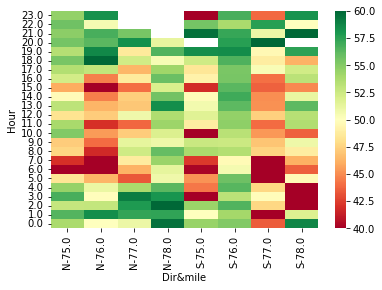

In [70]:
# Concatenate the 'Direction' and 'Milemarker' columns into a new column 'Dir&mile' 
# to create a unique identifier for each combination of direction and mile marker.
df_cr_summary['Dir&mile'] = df_cr_summary["Direction"].map(str) + "-" + df_cr_summary["Milemarker"].map(str)

# Pivot the data to create a heatmap-friendly structure. 
# 'Hour' will be the y-axis, 'Dir&mile' will be the x-axis, and 'avg_spd' will be the color scale.
df_cr_summary_heat = df_cr_summary.pivot("Hour", "Dir&mile", "avg_spd")

# Get the original order of y-axis labels (Hour) from the heatmap dataframe.
yticklabels = list(df_cr_summary_heat.index)

# Reverse the order of the y-axis labels to display properly in the heatmap.
yticklabels = yticklabels[::-1]

# Generate the heatmap using seaborn. We set color mapping to 'RdYlGn' and speed range to 40-60.
sns.heatmap(df_cr_summary_heat, cmap='RdYlGn', vmin=40, vmax=60, yticklabels=yticklabels)

# Show the plot.
plt.show()


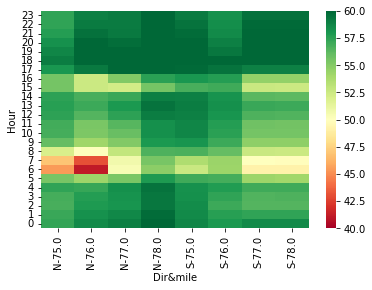

In [71]:
# Create a unique identifier 'Dir&mile' by combining the 'Direction' and 'Milemarker' columns. 
# This will help us to distinguish data by both direction and mile marker.
df_no_crash_summary['Dir&mile'] =  df_no_crash_summary["Direction"].map(str) + "-" + df_no_crash_summary["Milemarker"].map(str)

# Pivot the DataFrame to create a heatmap-friendly structure. 
# The 'Hour' column becomes the y-axis, 'Dir&mile' becomes the x-axis, and 'avg_spd' becomes the color scale.
df_no_crash_summary_heat = df_no_crash_summary.pivot("Hour", "Dir&mile", "avg_spd")

# Get the original y-axis labels (Hour) from the DataFrame to be used in the heatmap.
yticklabels = list(df_no_crash_summary_heat.index)

# Reverse the order of the y-axis labels to display them properly in the heatmap.
yticklabels = yticklabels[::-1]

# Generate the heatmap using seaborn. The color map is 'RdYlGn' and speed range is between 40 and 60.
sns.heatmap(df_no_crash_summary_heat, cmap='RdYlGn', vmin=40, vmax=60, yticklabels=yticklabels)

# Show the heatmap.
plt.show()


### [Back to Top](#Outline)